# Validation: Testing effect of leaving out CMs 
This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* tests the effect of leaving out CMs on overall CM effectiveness

In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import scipy
import copy

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor
import sensitivityplotlib as spl

sns.set_style("ticks")
%matplotlib inline

In [87]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("../final_data/data_final.csv")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Healthcare Infection Control
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


In [88]:
def leavout_cm(data, cm_leavouts, i):
    data_cm_leavout = copy.deepcopy(data)
    print('CM left out: ' + cm_leavouts[i])
    if cm_leavouts[i]=='None':
        pass
    else:
        data_cm_leavout.ActiveCMs = np.delete(data_cm_leavout.ActiveCMs, i, 1)
        data_cm_leavout.CMs = np.delete(data_cm_leavout.CMs, i)
    return data_cm_leavout

### Build and run models
skip if you already have traces

In [90]:
model_types = ['combined', 'active', 'death']
cm_leavouts = copy.deepcopy(data.CMs)
cm_leavouts.append('None')

In [91]:
for model_type in model_types:
    for i in range(len(cm_leavouts)):
        data_cm_leavout = leavout_cm(data, cm_leavouts, i)
        print('Model: ' + str(model_type))
        if model_type=='combined':         
            with cm_effect.models.CMCombined_Final(data_cm_leavout) as model:
                    model.build_model()  
        if model_type=='active':
            with cm_effect.models.CMActive_Final(data_cm_leavout) as model:
                    model.build_model()  
        if model_type=='death':
            with cm_effect.models.CMDeath_Final(data_cm_leavout) as model:
                    model.build_model()                      
                    
        model.run(1000, chains=8, cores=3)
        filename = 'out_final/cm_leavout_' + model_type + '_' + str(i) + '.txt'
        cm_trace = model.trace["CMReduction"]
        np.savetxt(filename, cm_trace)

CM left out: Mask Wearing
Model: death


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp02cyoolq/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp05k694po/key.pkl because the corresponding module is gone from the file system.


HyperCMVar_log__       -0.77
CM_Alpha               11.07
HyperRMean              0.67
HyperRVar_log__        -0.77
RegionLogR             28.31
Growth               5389.30
InitialSize_log      -226.49
Phi_log__              -0.77
ObservedCases      -29564.92
Name: Log-probability of test_point, dtype: float64


WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp09jff2vi/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp0d8xqwva/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp0k4a7ots/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp0uinj0pv/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp0yivurbs/key.pkl because the corres

WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp4oglrhxe/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp4unrkdm3/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp4xd0tiwz/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp53xwkbys/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp54oo7c_v/key.pkl because the corres

WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp90cm53zy/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp979y7e92/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp9gh1s0yg/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp9n5az5lb/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmp9tcisz8o/key.pkl because the corres

WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpddwll86q/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpdjc2xs3q/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpdls268_z/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpe6r3a36l/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpeb2iilds/key.pkl because the corres

WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmphzlxz7do/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpijshcstf/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpitc7s3q3/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpj27ngv24/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpj6e9emkw/key.pkl because the corres

WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpmbwvjpka/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpme5hac1p/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpmyo1vgw9/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpn7mj2zty/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpngbes7ml/key.pkl because the corres

WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmps1vebjgb/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpsf327r9z/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpso420zqq/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpspftli52/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpsv01wrt3/key.pkl because the corres

WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpx2zkvnqf/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpxg4px5op/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpxgig7da0/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpxj3eu5cm/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file /Users/annie/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.2-64/tmpyqv27s2d/key.pkl because the corres

KeyboardInterrupt: 

## Plot cm effectiveness

In [52]:
figsize=(8, 5)
colors = sns.color_palette("hls",10)
colors[-1] = [0,0,0]
y_offset = 0.08
y_scale = 1.5
fontsize=10
bbox_to_anchor = (1.1, 1.07)
cm_labels = data.CMs
legend_title='NPI Left Out'
legend_labels = cm_leavouts

##### plot combined model

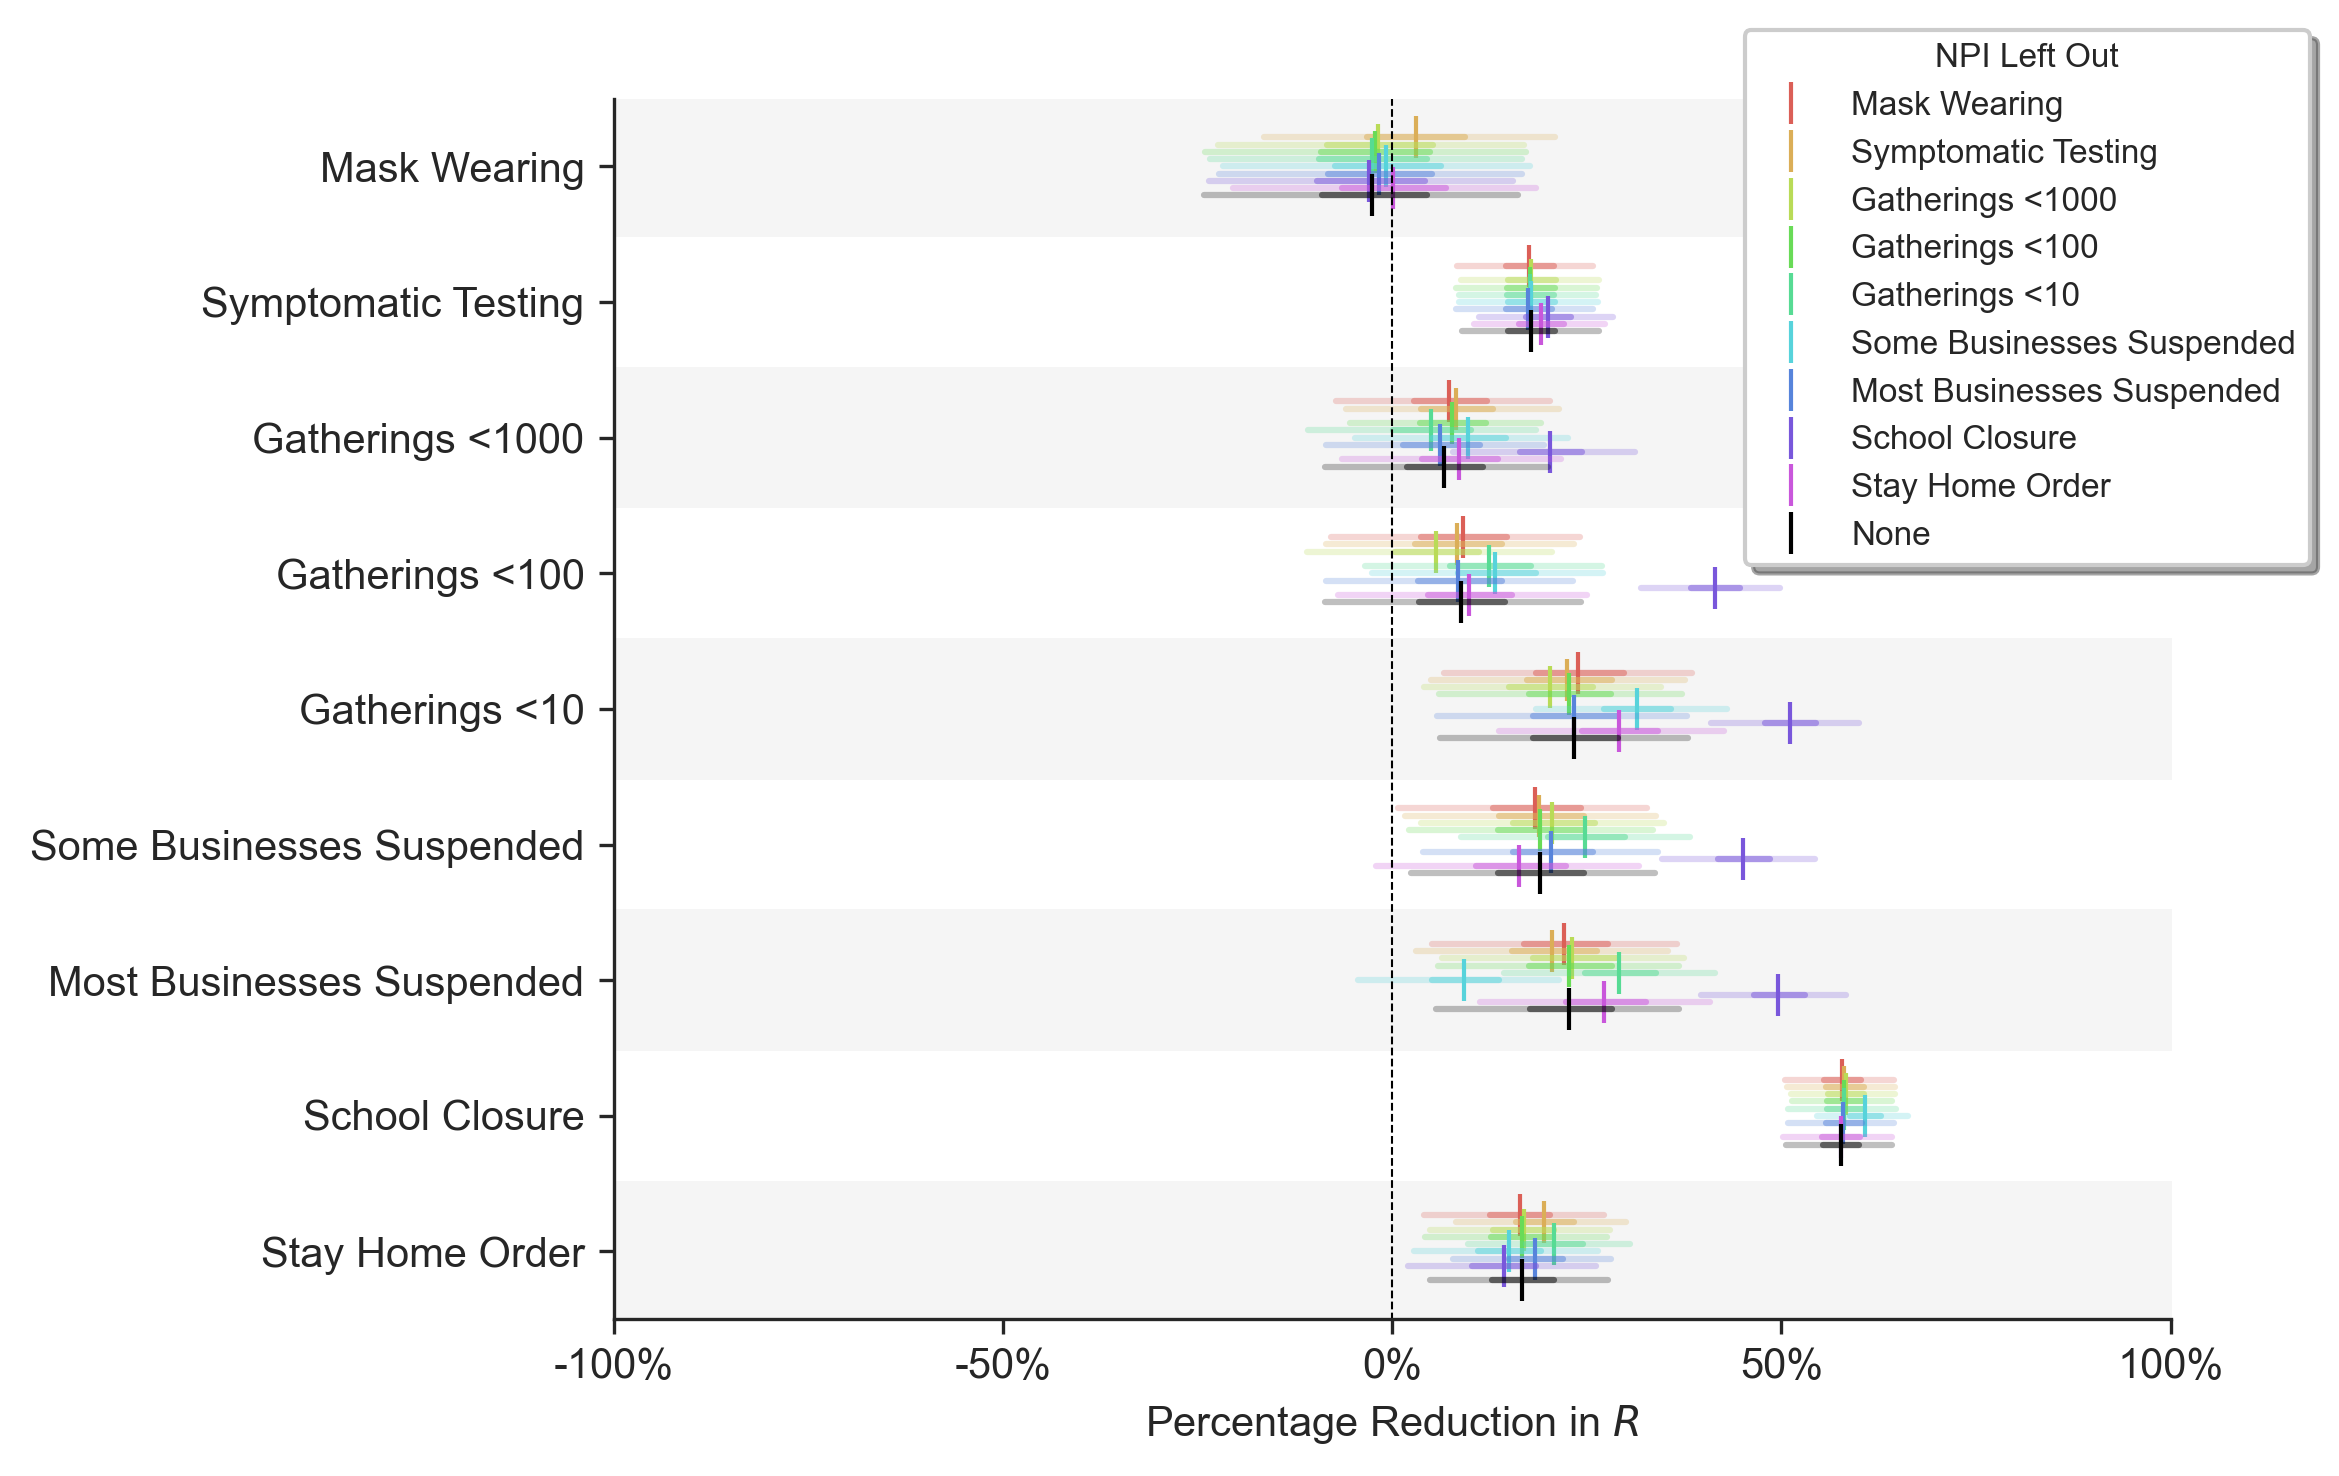

In [81]:
filenames = [f'out_final/cm_leavout_combined_{i}.txt' for i in range(len(cm_leavouts))]
import sensitivityplotlib as spl
spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels,
                               figsize=figsize,
                               legend_title=legend_title,
                               y_scale=y_scale,
                               y_offset=y_offset,
                               colors=colors,
                               leavouts=True,
                               bbox_to_anchor = bbox_to_anchor,
                               fontsize=fontsize)
plt.savefig('out_final/cm_leavout_sensitivity_combined_combos.pdf')

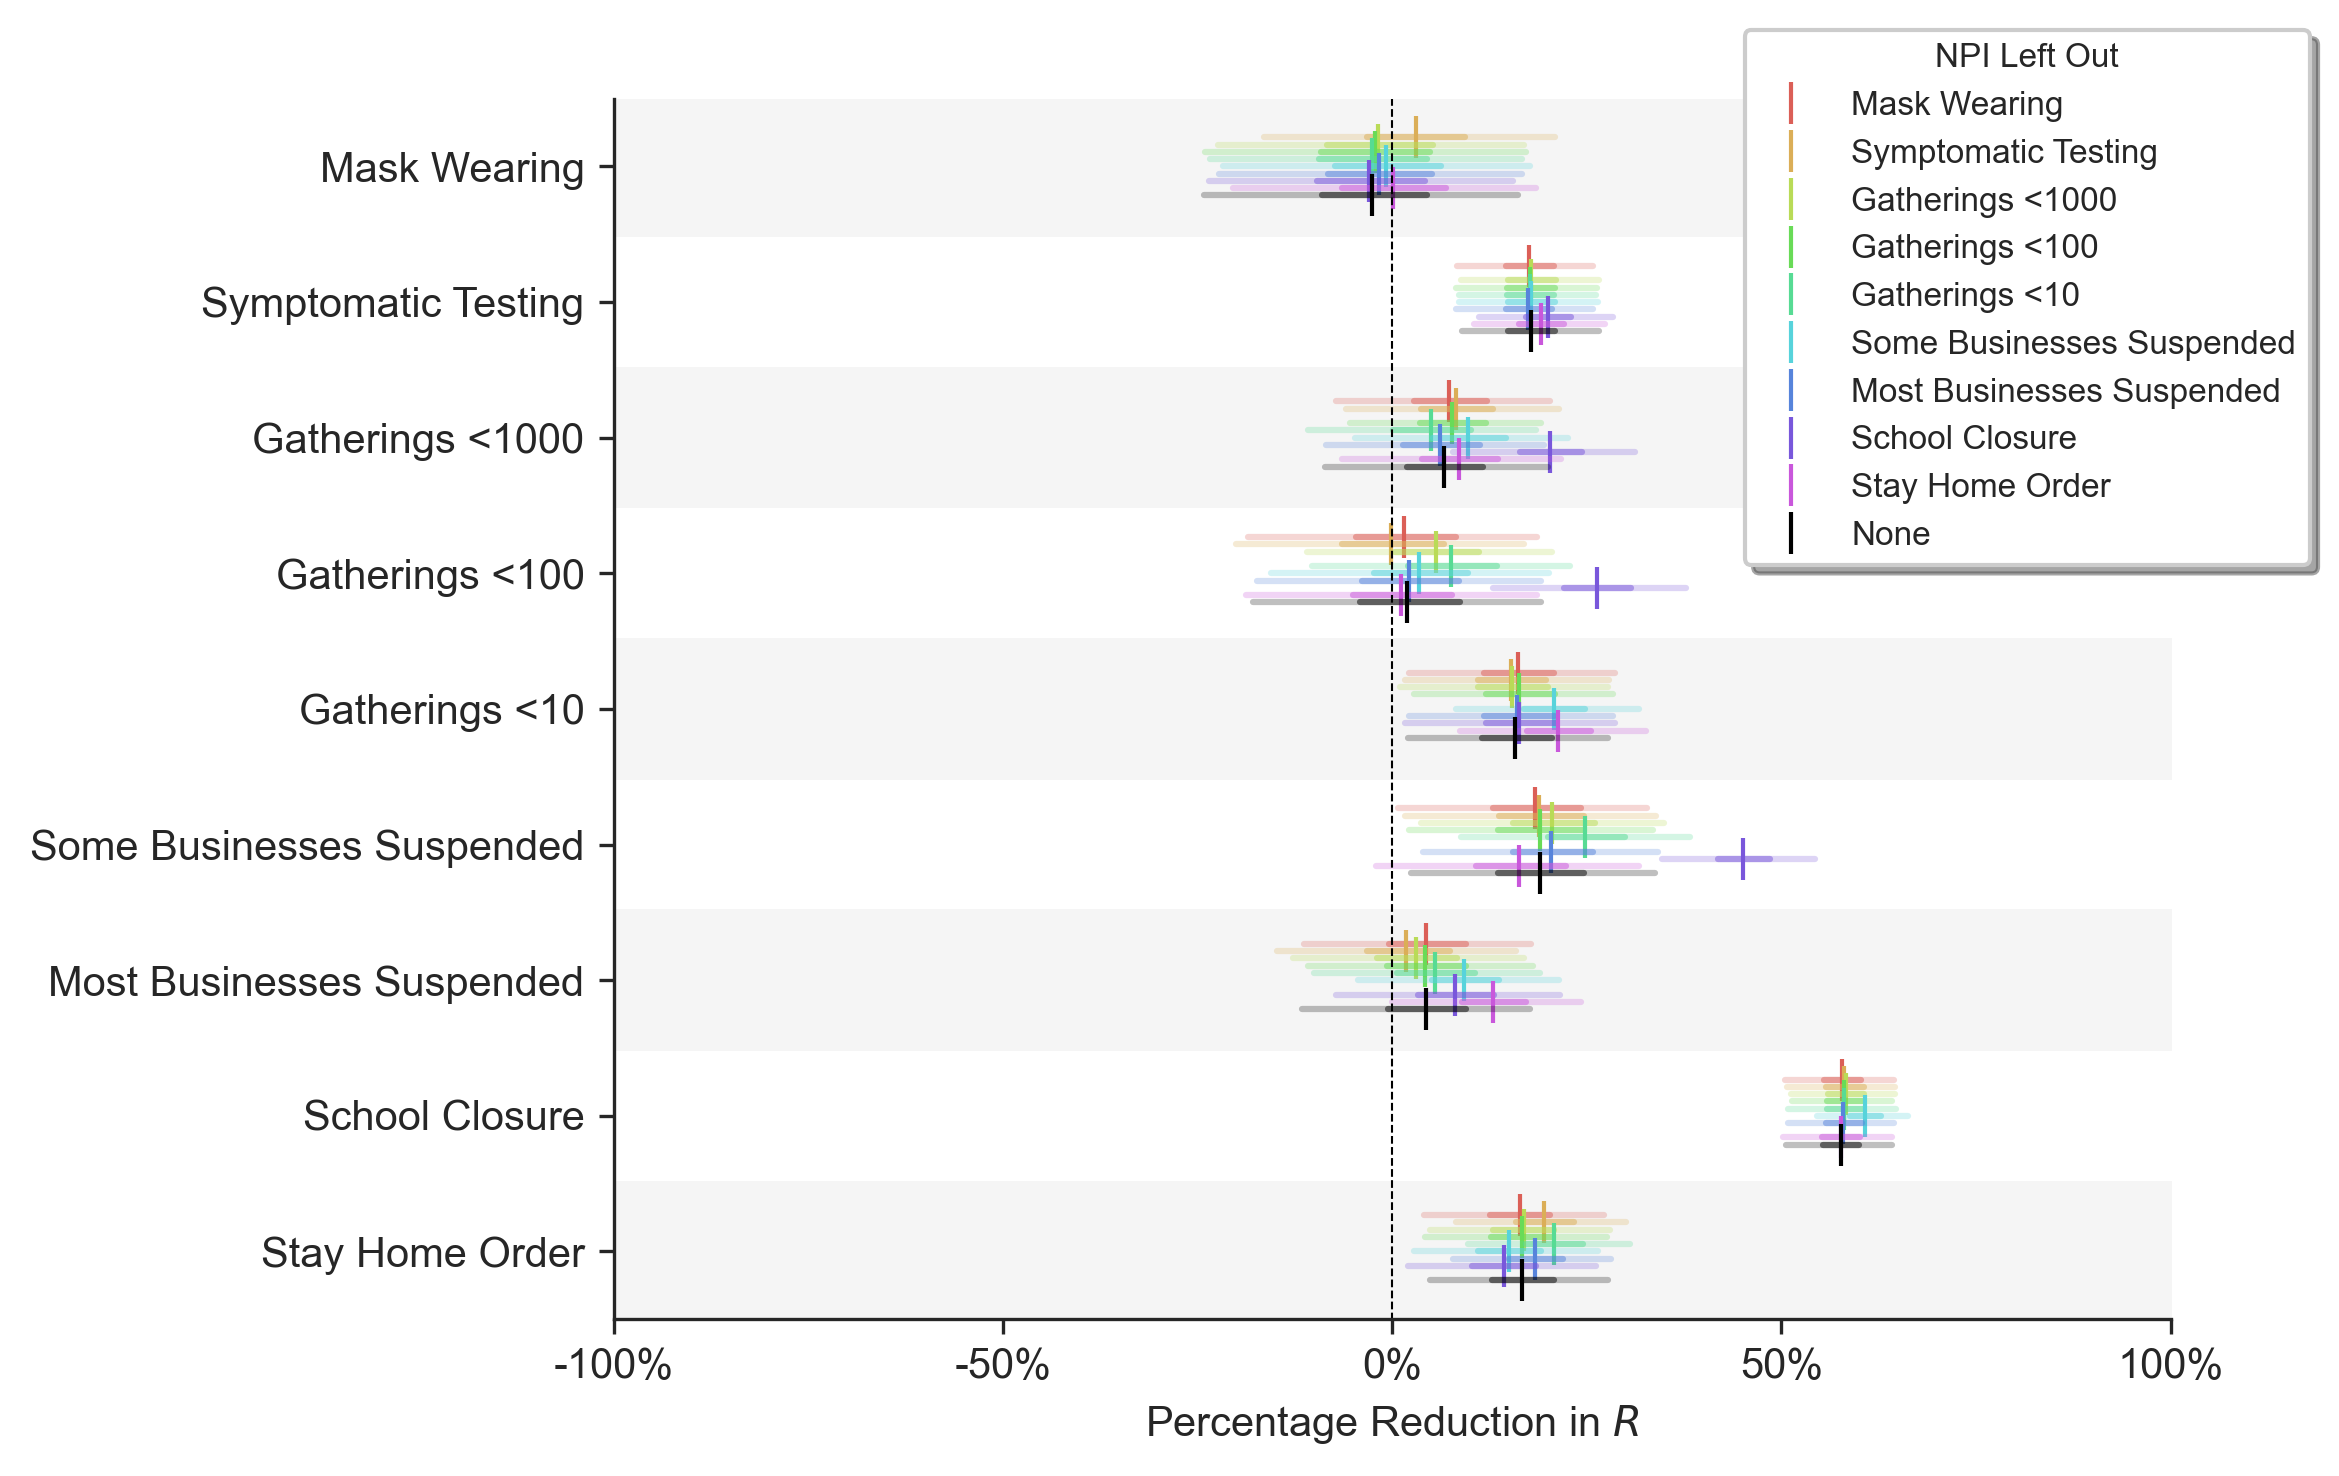

In [82]:
filenames = [f'out_final/cm_leavout_combined_{i}.txt' for i in range(len(cm_leavouts))]

spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels,
                               figsize=figsize,
                               legend_title=legend_title,
                               y_scale=y_scale,
                               y_offset=y_offset,
                               colors=colors,
                               leavouts=True,
                               bbox_to_anchor = bbox_to_anchor,
                               fontsize=fontsize,
                               combine_hierarchical=False)
plt.savefig('out_final/cm_leavout_sensitivity_combined.pdf')

##### plot active case model

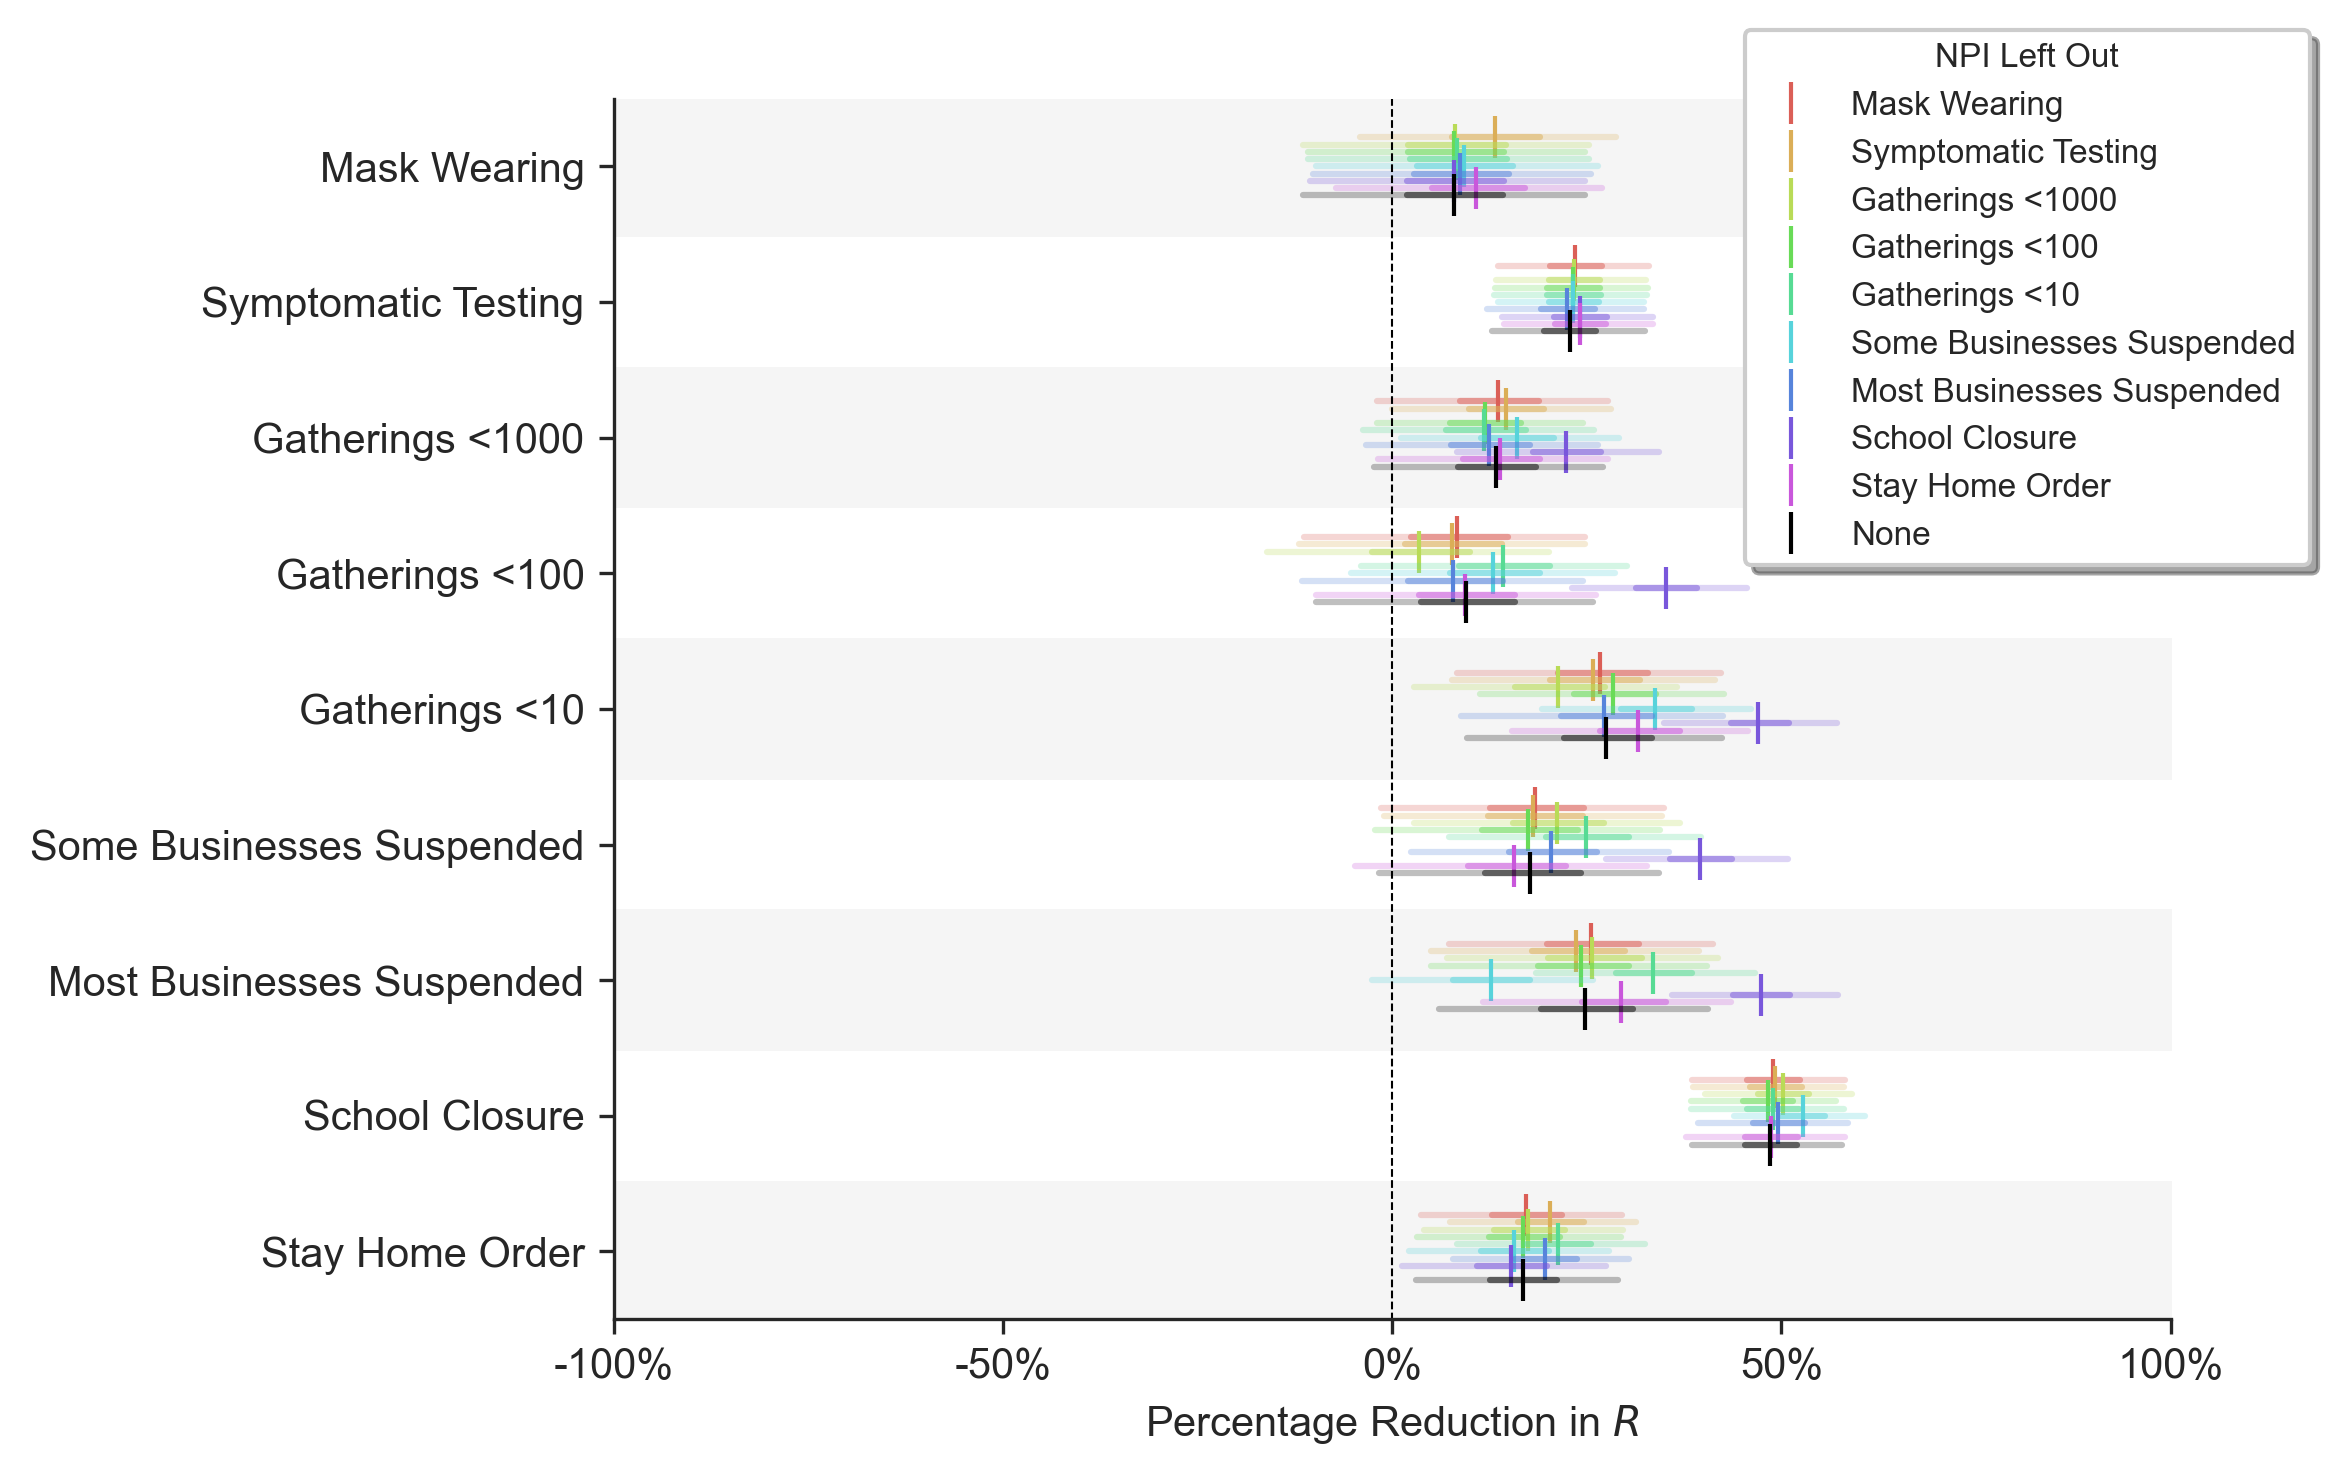

In [83]:
legend_labels = cm_leavouts
filenames = [f'out_final/cm_leavout_active_{i}.txt' for i in range(len(cm_leavouts))]
spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels,
                               figsize=figsize,
                               legend_title=legend_title,
                               y_scale=y_scale,
                               y_offset=y_offset,
                               colors=colors,
                               leavouts=True,
                               bbox_to_anchor = bbox_to_anchor,
                               fontsize=fontsize)
plt.savefig('out_final/cm_leavout_sensitivity_active_combos.pdf')

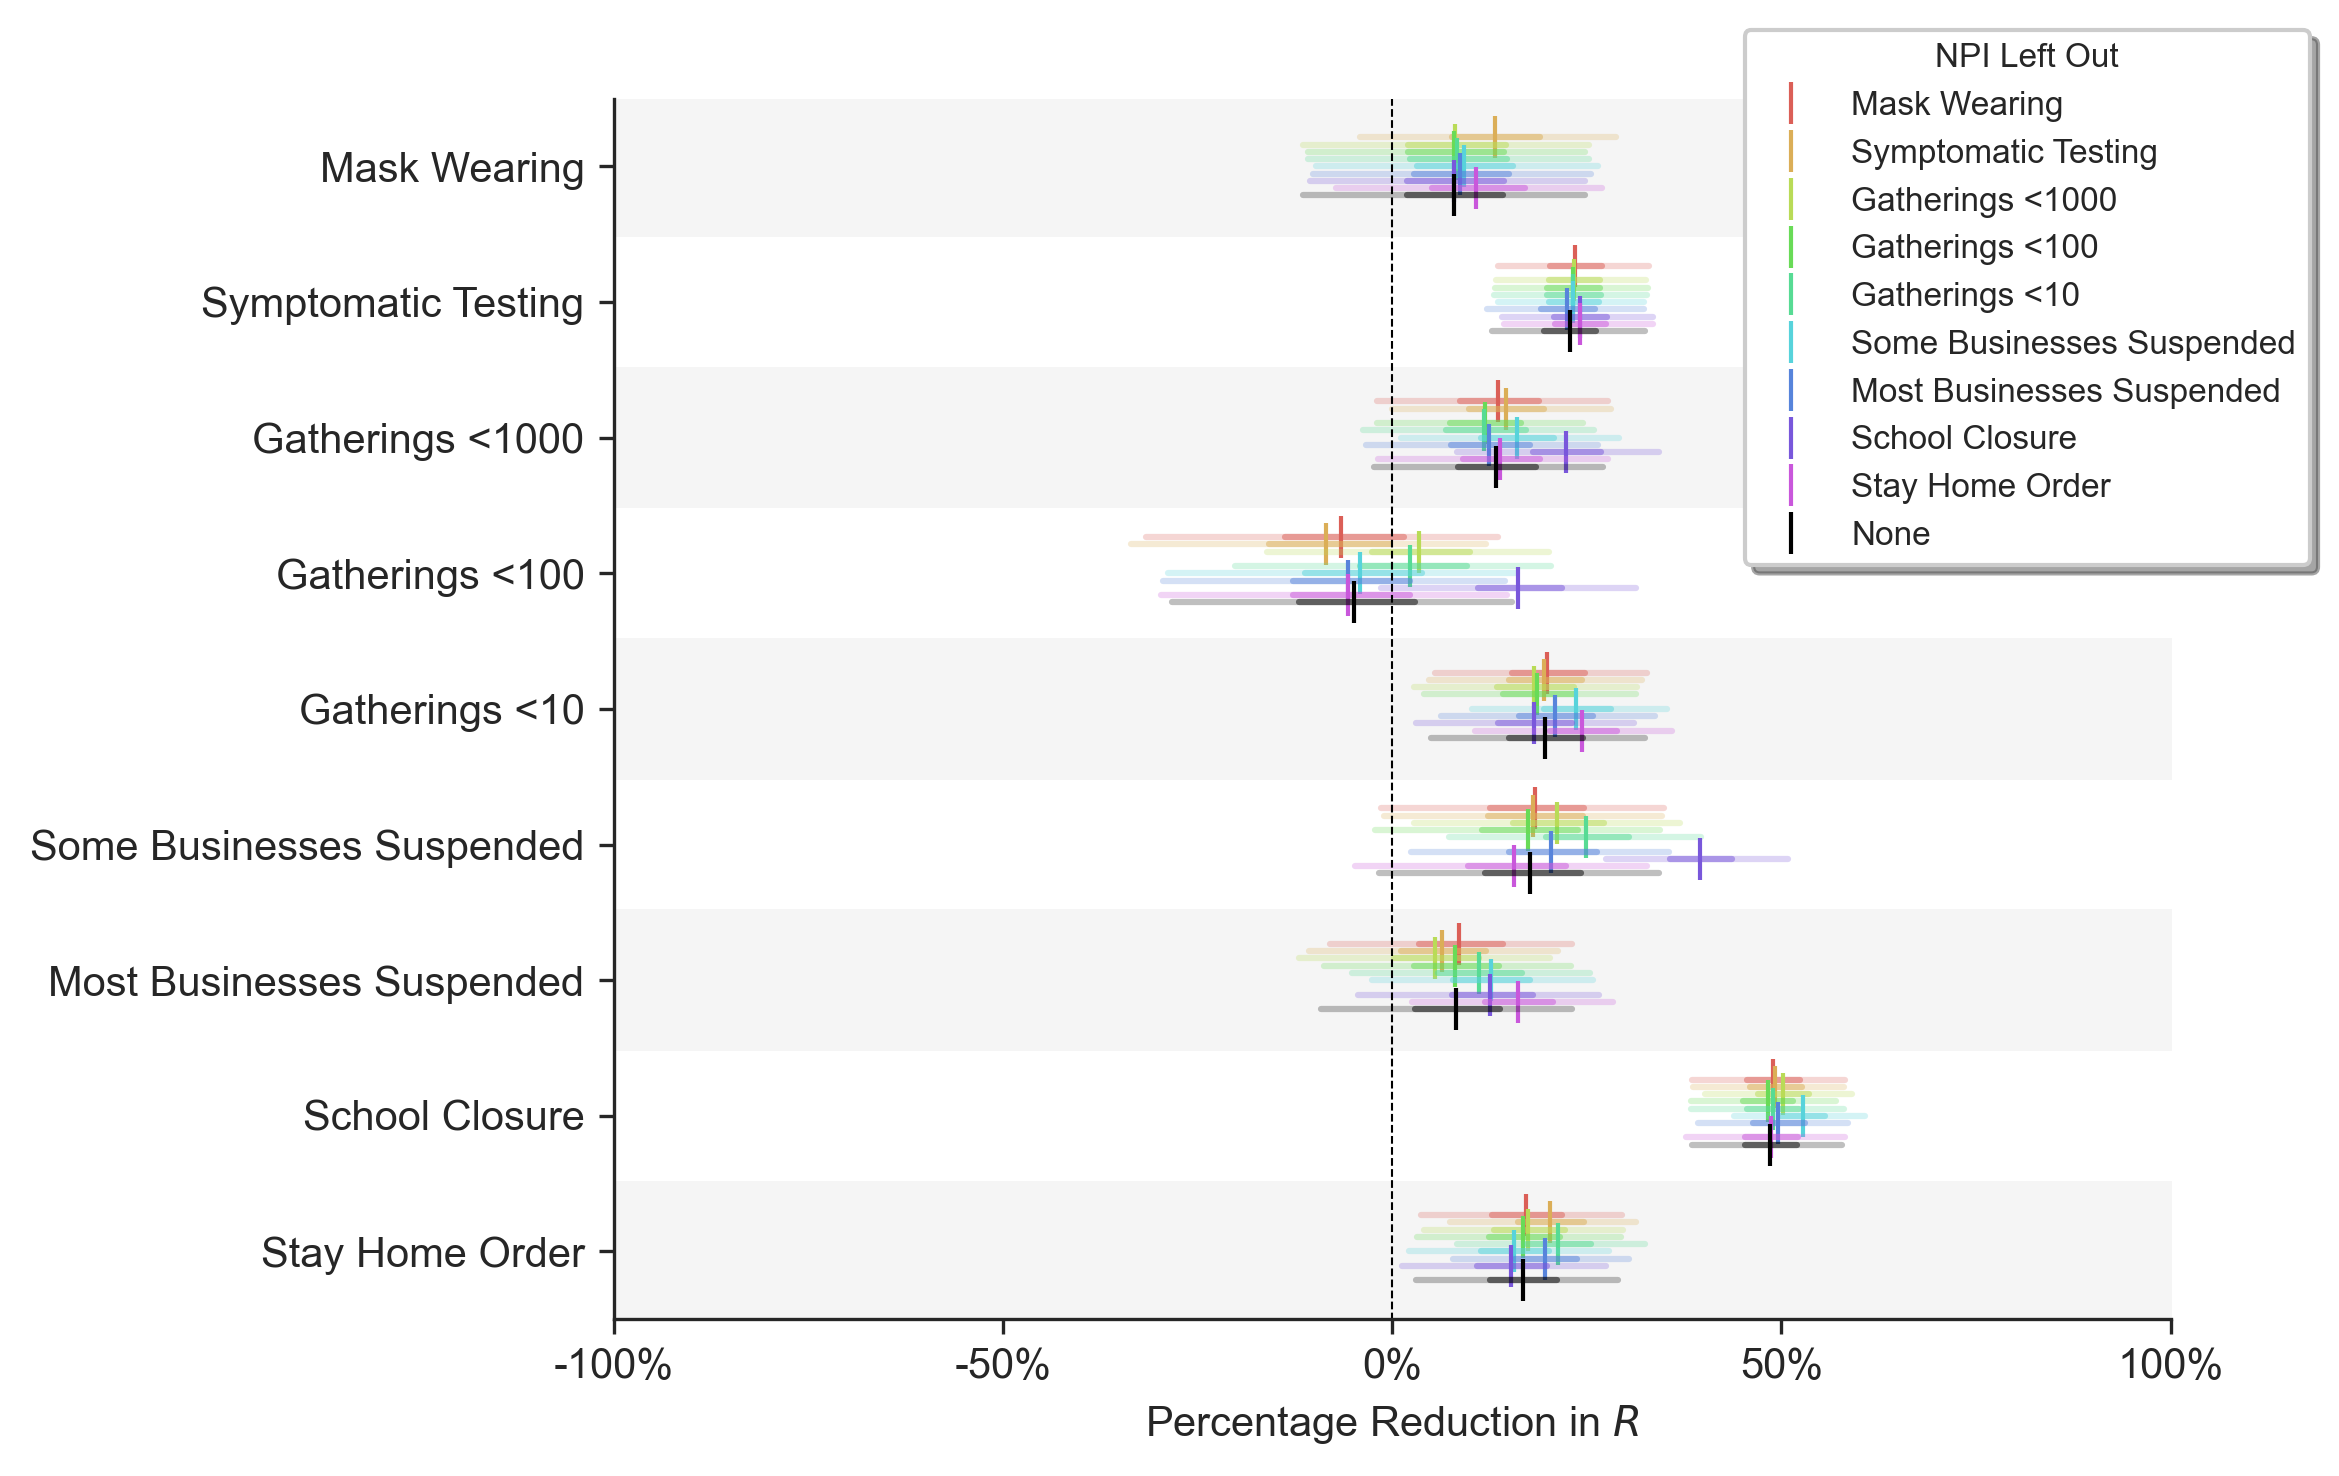

In [84]:
legend_labels = cm_leavouts
filenames = [f'out_final/cm_leavout_active_{i}.txt' for i in range(len(cm_leavouts))]
spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels,
                               figsize=figsize,
                               legend_title=legend_title,
                               y_scale=y_scale,
                               y_offset=y_offset,
                               colors=colors,
                               leavouts=True,
                               bbox_to_anchor = bbox_to_anchor,
                               fontsize=fontsize,
                               combine_hierarchical=False
                              )
plt.savefig('out_final/cm_leavout_sensitivity_active.pdf')

##### plot deaths model

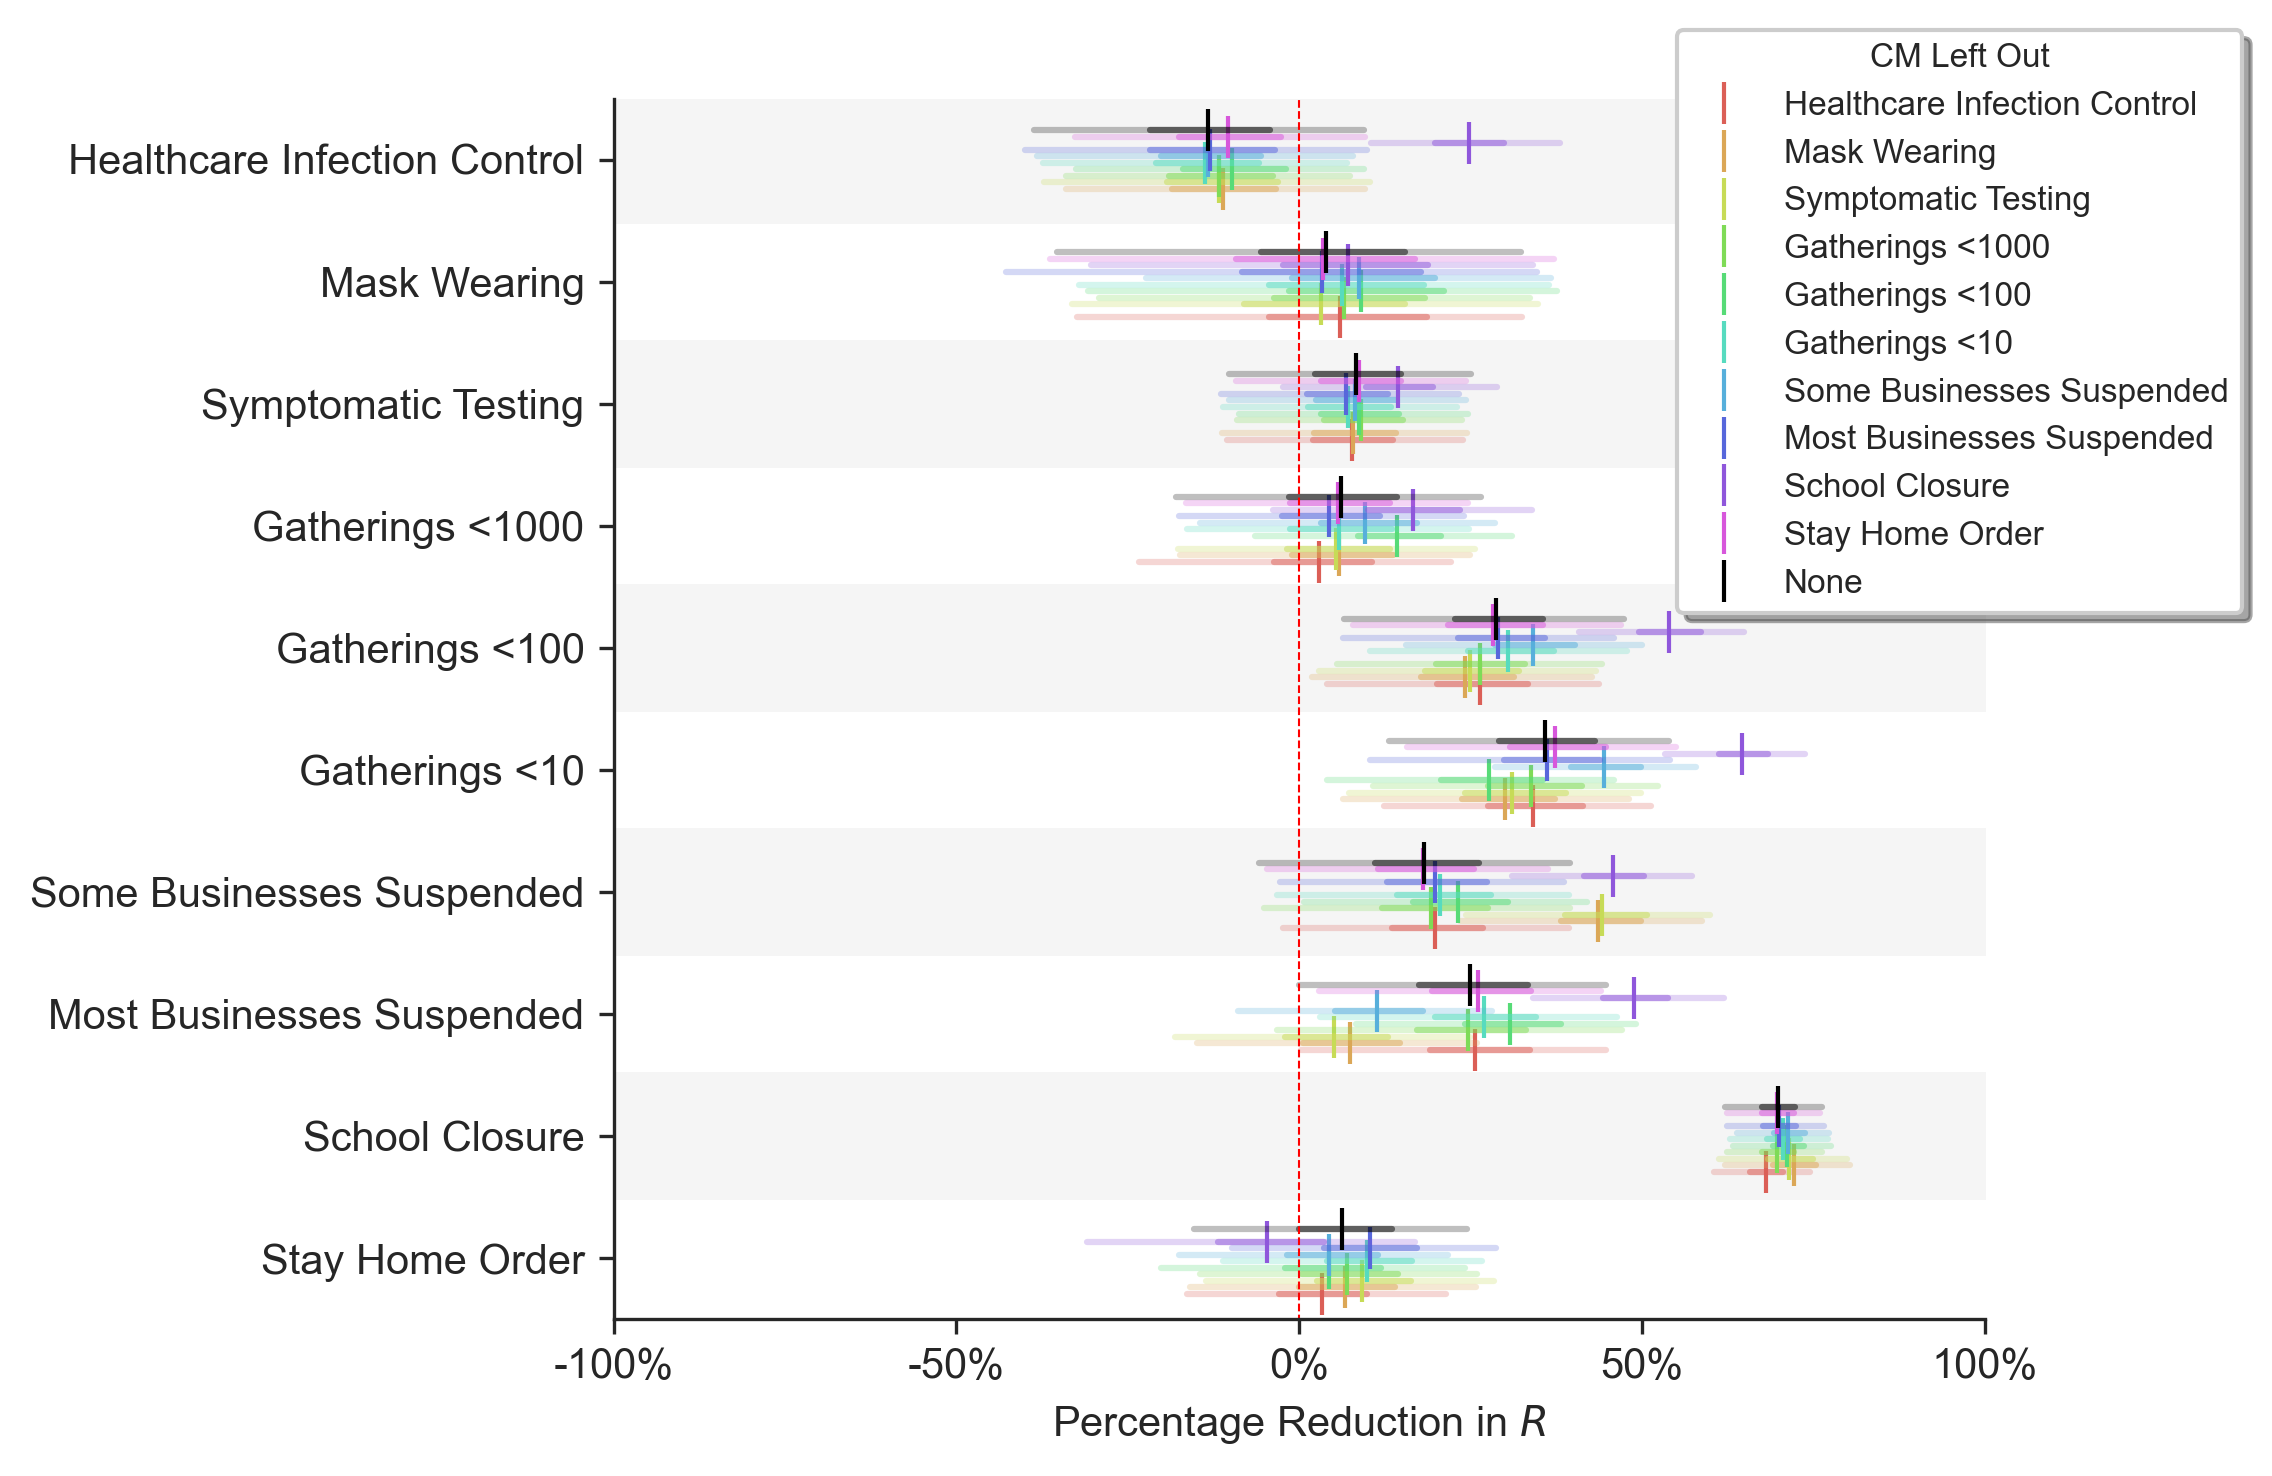

In [162]:
legend_labels = cm_leavouts
filenames = [f'out_final/cm_leavout_deaths_{i}.txt' for i in range(len(cm_leavouts))]

import sensitivityplotlib as spl
spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels, 
                               figsize=figsize,
                               legend_title=legend_title,
                               y_scale=y_scale,
                               y_offset=y_offset,
                               colors=colors,
                               leavouts=True,
                               bbox_to_anchor = bbox_to_anchor,
                               fontsize=fontsize)
plt.savefig('out_final/cm_leavout_deaths_sensitivity.pdf')